In [22]:
import sqlite3
from datetime import date, datetime
from typing import Optional
import pytz
from pyprojroot import here
from langchain_core.runnables import ensure_config
from langchain_core.tools import tool

from typing import List
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig


import os
from dotenv import load_dotenv
import yaml
from pyprojroot import here
from langchain_openai import ChatOpenAI
load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['OPENAI_API_BASE'] = os.getenv("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
OPENAI_API_BASE= os.environ.get("OPENAI_API_BASE")



In [23]:
sqldb_directory = here("data/travel2.sqlite")

# database will be used throughout this module in flight methods

# 1. 连接到 SQLite 数据库
conn = sqlite3.connect(sqldb_directory)

# conn

# # 2. 创建游标对象
# cursor = conn.cursor()

# # 3. 查询所有表名
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")

# # 4. 获取查询结果
# tables = cursor.fetchall()

# # 5. 输出所有表名
# print("数据库中的表：")
# for table in tables:
#     print(table[0])

# # 6. 关闭游标和连接
# cursor.close()
# conn.close()

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_base=OPENAI_API_BASE,
    openai_api_key=OPENAI_API_KEY,
    # tream=True,
    model="gpt-4o-mini",
    temperature=0)

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello, how are you?"}
]

# # Call the model with the messages
# response = llm.invoke(messages)

# # Print the response
# print(response)
# print('\n')
# print(response.content)



In [25]:
@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(sqldb_directory)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

In [26]:
@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range.

    Args:
        departure_airport (Optional[str]): The airport code from which the flight is departing.
        arrival_airport (Optional[str]): The airport code where the flight is arriving.
        start_time (Optional[date | datetime]): The earliest departure time to filter flights.
        end_time (Optional[date | datetime]): The latest departure time to filter flights.
        limit (int): The maximum number of flights to return. Defaults to 20.

    Returns:
        list[dict]: A list of dictionaries where each dictionary contains the details of a flight
            including all columns from the flights table.
    """
    conn = sqlite3.connect(sqldb_directory)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)

    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


In [27]:
tools = [fetch_user_flight_information,search_flights]

In [28]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [29]:
import shutil
import pandas as pd
import sqlite3
from typing import Callable
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
# from build_agent_state import State


def handle_tool_error(state) -> dict:
    """
    Handles errors by formatting them into a message and adding them to the chat history.

    This function retrieves the error from the given state and formats it into a `ToolMessage`, which is then
    added to the chat history. It uses the latest tool calls from the state to attach the error message.

    Args:
        state (dict): The current state of the tool, which includes error information and tool calls.

    Returns:
        dict: A dictionary containing a list of `ToolMessage` objects with error information.
    """
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }
    
def create_tool_node_with_fallback(tools: list) -> dict:
    """
    Creates a `ToolNode` with fallback error handling.

    This function creates a `ToolNode` object and configures it to use a fallback function for error handling. 
    The fallback function handles errors by calling `handle_tool_error`.

    Args:
        tools (list): A list of tools to be included in the `ToolNode`.

    Returns:
        dict: A `ToolNode` configured with fallback error handling.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

In [8]:
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

In [30]:
from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

In [31]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))

builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")

# Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

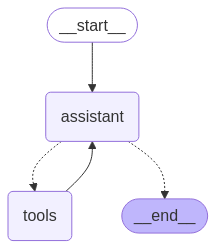

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [32]:
def _print_event(event: dict, _printed: set, max_length=1500):
    """
    Prints the current state and messages of an event, with optional truncation for long messages.

    This function prints information about the current dialog state and the latest message in the event. If the message 
    is too long, it is truncated to a specified maximum length.

    Args:
        event (dict): The event containing dialog state and messages.
        _printed (set): A set of message IDs that have already been printed, to avoid duplicate output.
        max_length (int, optional): The maximum length of the message to print before truncating. Defaults to 1500.
    """
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [34]:
from langchain_core.messages import HumanMessage


inputs = {"messages": [HumanMessage(content="Hi there, what time is my flight?")]}
for chunk in graph.stream(
    inputs, {"configurable": {"passenger_id": "8149 604011"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()



================================ Human Message =================================

Query the ticket to Beijing, the requirement is to arrive after 2025-05-02, Query the format of date is 2025-05-02，do not add the starting place
================================== Ai Message ==================================
Tool Calls:
  search_flights (chatcmpl-vVC4ULsJSLhLqf8ruOY6LcVA5qeBO)
 Call ID: chatcmpl-vVC4ULsJSLhLqf8ruOY6LcVA5qeBO
  Args:
    arrival_airport: BJS
    start_time: 2025-05-02
    limit: 20
================================= Tool Message =================================
Name: search_flights

[]
================================== Ai Message ==================================
Tool Calls:
  search_flights (chatcmpl-X7cfy6MAi0KGEBkyJENesNTcx4sBZ)
 Call ID: chatcmpl-X7cfy6MAi0KGEBkyJENesNTcx4sBZ
  Args:
    arrival_airport: BJS
    start_time: 2025-05-02T00:00:00
    limit: 20
================================= Tool Message =================================
Name: search_flights

Your fl

In [47]:
import uuid
thread_id = str(uuid.uuid4())

_printed = set()

question = "Query the ticket to Beijing, the requirement is to arrive after 2025-05-02, Query the format of date is 2025-05-02，do not add the starting place"
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

inputs = {"messages": [HumanMessage(content="Query for flight tickets to Beijing after the date 2024-05-2")]}
for chunk in graph.stream(
    inputs, {"configurable": {"passenger_id": "8149 604011"}}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Query for flight tickets to Beijing after the date 2024-05-2
================================== Ai Message ==================================
Tool Calls:
  search_flights (chatcmpl-QYdVtIQknHAmMuKpRATXdcmoVCt7Y)
 Call ID: chatcmpl-QYdVtIQknHAmMuKpRATXdcmoVCt7Y
  Args:
    arrival_airport: BJS
    start_time: 2025-05-02T00:00:00
    end_time: 2025-12-31T23:59:59
    limit: 20
================================= Tool Message =================================
Name: search_flights

[]
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (chatcmpl-ZkIchl8eNXs62svZMiM9kPVzizHCG)
 Call ID: chatcmpl-ZkIchl8eNXs62svZMiM9kPVzizHCG
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX